In [23]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import glob
import time
import math

import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [24]:
car_far = glob.glob('vehicles/GTI_Far/image*.png')
car_right = glob.glob('vehicles/GTI_Right/image*.png')
car_left = glob.glob('vehicles/GTI_Left/image*.png')
car_middleclose = glob.glob('vehicles/GTI_MiddleClose/image*.png')
car_extracted = glob.glob('vehicles/KITTI_extracted/*.png')
cars = car_far + car_left + car_right + car_middleclose + car_extracted
shuffle(cars)

not_car_extras = glob.glob('non-vehicles/Extras/extra*.png')
not_car_gti = glob.glob('non-vehicles/GTI/image*.png')
not_cars = not_car_extras + not_car_gti
shuffle(not_cars)
# not_cars = not_cars[0:len(cars)]

print("Number of Car Images:",len(cars))
print("Number of Non-Car Images:",len(not_cars))

Number of Car Images: 8792
Number of Non-Car Images: 8968


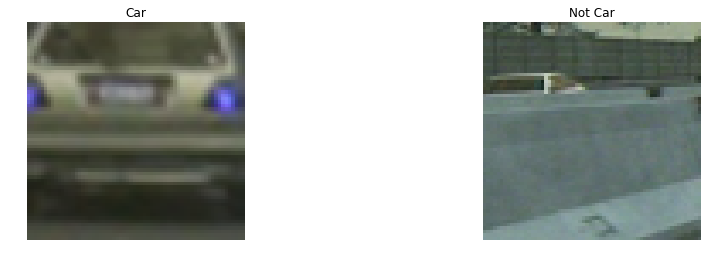

In [25]:
def rand_image(cars,not_cars):
    car_rep = np.random.randint(0, len(cars))
    not_car_rep = np.random.randint(0, len(not_cars))
    car_rep_image = cv2.imread(cars[car_rep])
    not_car_rep_image = cv2.imread(not_cars[not_car_rep])
    return car_rep_image, not_car_rep_image

my_random_car, my_random_not_car = rand_image(cars, not_cars)

fig, axs = plt.subplots(1,2, figsize=(15, 4))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car')
axs[0].imshow(my_random_car)

axs[1].axis('off')
axs[1].set_title('Not Car')
axs[1].imshow(my_random_not_car)

In [26]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

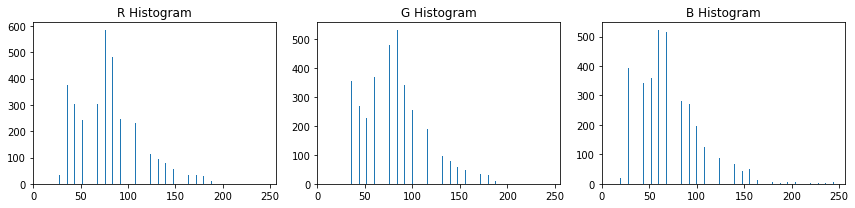

In [27]:
rh, gh,bh, bincen, hist_features_car = color_hist(my_random_car, nbins =32, bins_range =(0,256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [28]:
# # Define HOG parameters
# color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
# orient = 32
# pix_per_cell = 16
# cell_per_block = 2
# hog_channel = 'ALL' 
# spatial_size=(32, 32)
# hist_bins=32
# spatial_feat=True
# hist_feat=True
# hog_feat=True

In [29]:
# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

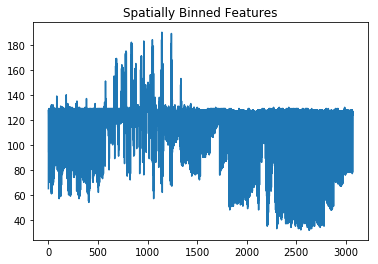

In [30]:
feature_vec = bin_spatial(my_random_car, color_space='YCrCb', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [31]:
# Define HOG parameters
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
# hog_channel = 'ALL' 
# spatial_size=(32, 32)
# hist_bins=32
# spatial_feat=True
# hist_feat=True
# hog_feat=True

In [32]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Hog features shape: (3, 3, 2, 2, 32)
Flattenned Hog features size: (1152,)


/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


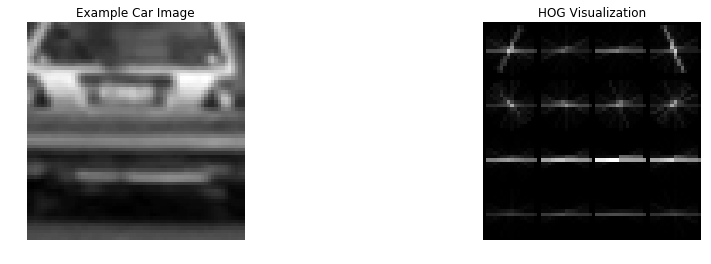

In [33]:
my_random_car_gray = cv2.cvtColor(my_random_car, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(my_random_car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

hog_1d = np.ravel(features)
print('Hog features shape:', features.shape)
print('Flattenned Hog features size:', hog_1d.shape)

# Plot the examples
fig, axs = plt.subplots(1,2, figsize=(15, 4))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Example Car Image')
axs[0].imshow(my_random_car_gray, cmap='gray')

axs[1].axis('off')
axs[1].set_title('HOG Visualization')
axs[1].imshow(hog_image, cmap='gray')

In [34]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=16, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        if hist_feat == True:
            # Apply color_hist()
            rh, gh,bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)

        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list

        features.append(np.concatenate((spatial_features, hist_features, hog_features),axis = 0))
    # Return list of feature vectors
    return  features

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


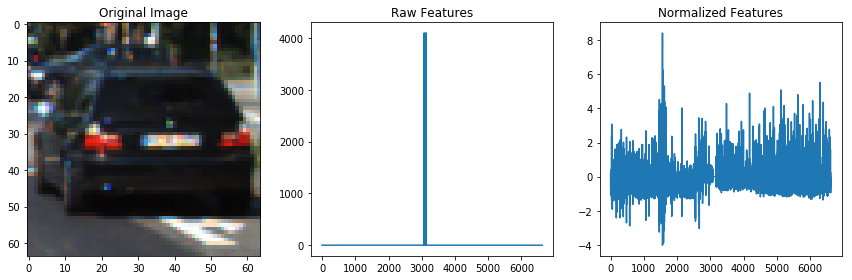

In [35]:
# Define Feature Extracion Parameters

# color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
# spatial_size=(32, 32)
# hist_bins=32
# orient = 32
# pix_per_cell = 16
# cell_per_block = 2
# hog_channel = 'All'
# spatial_feat=True
# hist_feat=True
# hog_feat=True

color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' 
spatial_size=(32, 32)
hist_bins=32
spatial_feat=True
hist_feat=True
hog_feat=True

car_features = extract_features(cars, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block,
                        hog_channel,spatial_feat, hist_feat, hog_feat)

notcar_features = extract_features(not_cars, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block,
                        hog_channel,spatial_feat, hist_feat, hog_feat)

if len(car_features) > 0:
    #normalize feature
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [36]:
# URRR
# Define a labels vector based on features lists

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# train the classifier
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
# Train the SVC
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9873
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00178 Seconds to predict 10 labels with SVC


In [37]:
# URRR
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [38]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [39]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=32, 
                    pix_per_cell= 16, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [40]:
# extract features for a single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=32, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rh, gh,bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'all':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [41]:
def get_hot_boxes (image):

    draw_image = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size_dst, overlap in zip (window_x_limits, window_y_limits, window_size_src, window_overlap):

        windows = slide_window(
            draw_image,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window= window_size_dst,
            xy_overlap=overlap
        )

        hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,hist_range = (0,256),
                        orient = orient, pix_per_cell= pix_per_cell, 
                        cell_per_block= 2, 
                        hog_channel= 'all', spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                          
        
        all_hot_windows.extend (hot_windows)
        
        img_1windowsize = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)
    img_allwindowsize = draw_boxes(draw_image,all_hot_windows, color =(0,0,1),thick = 4)
    return all_hot_windows, img_1windowsize,img_allwindowsize

In [42]:
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# define a function to run through all 3 types of windows
window_x_limits = [[None, None],
                   [40, None],
                   [400, 1280]]

window_y_limits = [[380, 640],
                   [400, 600],
                   [440, 560]]

window_size_src = [(128, 128),
                   (96, 96),
                   (64, 64)]

window_overlap = [(0.6, 0.6),
                  (0.7, 0.7),
                  (0.8, 0.8)]

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 6624


/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


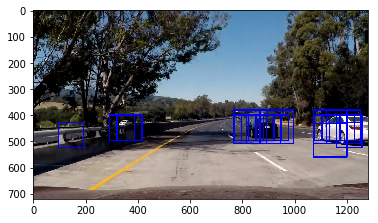

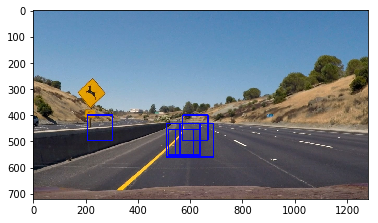

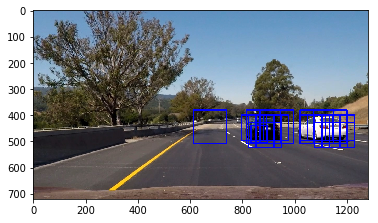

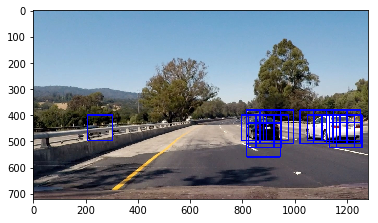

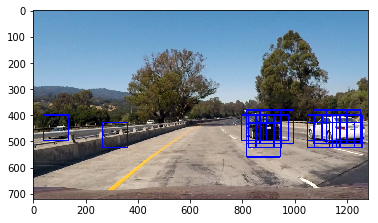

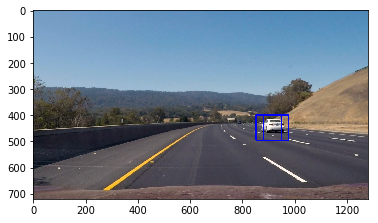

In [43]:
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

for image_test in glob.glob('test_images/test*.jpg'):
    # load testing image:
    test_image = mpimg.imread(image_test)
    draw_image = np.copy(test_image)

    test_image_n = test_image.astype(np.float32)/255

    # create sliding windows
    windows1 = slide_window(test_image_n, x_start_stop=window_x_limits[0], y_start_stop=window_y_limits[0], 
                        xy_window=window_size_src[0], xy_overlap=window_overlap[0])

    windows2 = slide_window(test_image_n, x_start_stop=window_x_limits[1], y_start_stop=window_y_limits[1], 
                        xy_window=window_size_src[1], xy_overlap=window_overlap[1])

    windows3 = slide_window(test_image_n, x_start_stop=window_x_limits[2], y_start_stop=window_y_limits[2], 
                        xy_window=window_size_src[2], xy_overlap=window_overlap[2])
    all_window = []
    all_window.extend(windows1)
    all_window.extend(windows2)
    all_window.extend(windows3)

    img_allslidingwindow = draw_boxes(draw_image, all_window, color=(0, 0, 255), thick=4)                  
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(test_image_n)

    plt.figure()
    plt.imshow(img_allwindow)

In [44]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


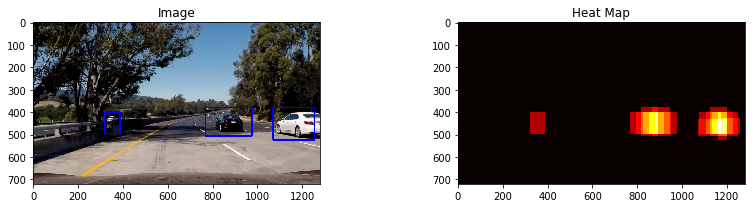

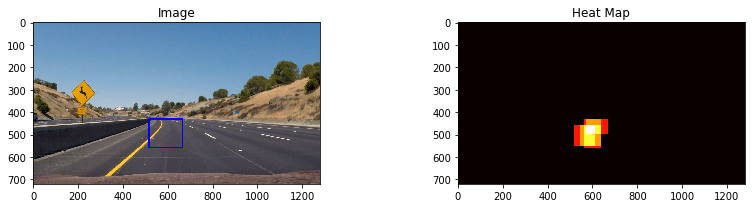

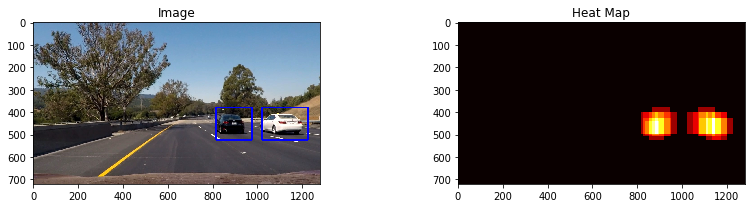

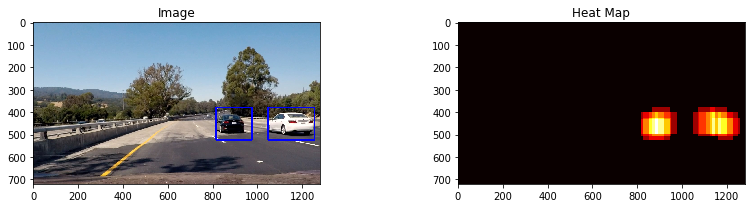

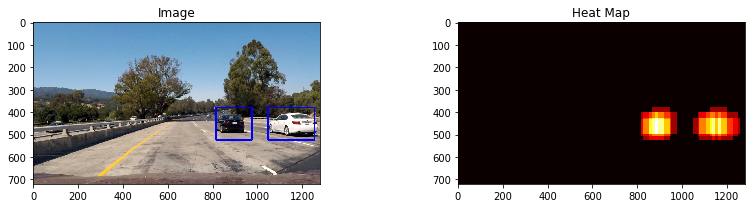

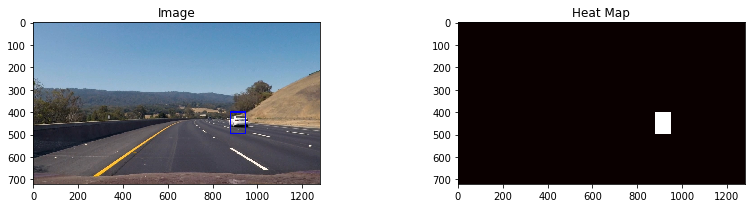

In [45]:
global heatmap_combined

heatmap_combined = np.zeros_like(img_allwindow[:,:,0]).astype(np.float)

for image_test in glob.glob('test_images/test*.jpg'):
    # load testing image:
    test_image = mpimg.imread(image_test)
    draw_image = np.copy(test_image)
    
    draw_image_norm = draw_image.astype(np.float32)/255
    hot_window = []
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(draw_image_norm)

    # Add heat to each box in box list
    heat_img = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = add_heat(heat_img, hot_window)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmap_combined = heatmap_combined + heatmap

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(test_image), labels)

    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(draw_image)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [46]:
def process_frame(img):  
    
    global extended_heatmap
    global total_heatmap
    global frame_index
    
    frame_index = 0
    extended_heatmap = []
    total_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_image = np.copy(img)
    test_image_norm = img.astype(np.float32)/255
    hot_window = []
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(test_image_norm)

    # Add heat to each box in box list
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat_img, hot_window)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # add current heat map to overall heap map for 5 frames
    if (frame_index < 10):
        extended_heatmap.append(heatmap) 
        frame_index += 1
        total_heatmap = heatmap
    else:
        extended_heatmap.pop(0)
        extended_heatmap.append(heatmap)
        total_heatmap -= heatmap[0]
        total_heatmap += heatmap[9]
        
    # Find final boxes from heatmap using label function
    total_heatmap = apply_threshold(total_heatmap,1)
    labels = label(total_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'vehicle_detected.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,30)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video vehicle_detected.mp4
[MoviePy] Writing video vehicle_detected.mp4


 69%|██████▉   | 872/1261 [29:41<13:12,  2.04s/it]

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))